In [2]:
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

# Read image segmentation training data back from tfrecords

In [create_training_samples](create_training_samples.ipynb) we create folders of images and accompanying ground truth data, in GeoTIFF format.

In [translate_chips_to_tfrecords](./translate_chips_to_tfrecords.ipynb) we have several different ways for converting folders of images in this format into TFRecords. The tfrecords can either contain the raw encoded images, or the decoded pixel data as arrays. In the case of array data, the data can be stored either encoded as BytesList features or as Float64List features. 

In this notebook, we demonstrate the ways that each of these types of TFRecord can be parsed to tensorflow features for use in a training pipeline.

Illustrations are provided for datasets stored in five different ways:
- '**...tifraw**': geotiff images (may be >8 bit, >3 bands) stored directly as bytes in the file, needs decoding using GDAL/rasterio
- '**...tifarr**': array data decoded from geotiff images (>8bit, >3 bands) stored as Float64List in the file. This is equivalent to the original Descartes Labs wellpads sample.
- '**...rgbraw_png**': RGB PNG images (8 bit, 1 or 3 bands) stored directly as bytes in the file in a format that can be decoded using tensorflow (PNG or JPG)
- '**...rgbraw_tif**': an RGB image (8 bit, 1 or 3 bands) stored directly as bytes in the file in any GDAL-compatible format, for decoding with GDAL/rasterio
- '**...rgbarr**': array data decoded from RGB PNG images (8 bit, 1 or 3 bands), stored as bytes in the file

In [3]:
_base = 'C:/Users/harry/OneDrive - Nexus365/Informal_Cities/ML_Slum_Prediction/Ground_Truthing_Data/Sample_TFRecords'

tf_folder_tifraw = os.path.join(_base, 'tf_sample_sentinel-SR_raw')
tf_folder_tifarr = os.path.join(_base, 'tf_sample_sentinel-SR_arr')
tf_folder_rgbraw_png = os.path.join(_base, 'tf_sample_pleiades_raw_png')
tf_folder_rgbraw_tif = os.path.join(_base, 'tf_sample_pleiades_raw_tif')
tf_folder_rgbarr = os.path.join(_base, 'tf_sample_pleiades_arr')


To read the sharded (multiple-files) dataset we just pass a list of files rather than only one. 

Create a `TFRecordDataset` for each dataset, and read one example from each, for now

In [3]:
_tf_files = glob.glob(os.path.join(tf_folder_tifraw, '*'))
_dataset_tifraw = tf.data.TFRecordDataset(filenames=_tf_files)
eg_tifraw = next(iter(_dataset_tifraw))

_tf_files = glob.glob(os.path.join(tf_folder_tifarr, '*'))
_dataset_tifarr = tf.data.TFRecordDataset(filenames=_tf_files)
eg_tifarr = next(iter(_dataset_tifarr))

_tf_files = glob.glob(os.path.join(tf_folder_rgbraw_tif, '*'))
_dataset_rgbraw_gdal = tf.data.TFRecordDataset(filenames=_tf_files)
eg_rgbraw_gdal = next(iter(_dataset_rgbraw_gdal))

_tf_files = glob.glob(os.path.join(tf_folder_rgbraw_png, '*'))
_dataset_rgbraw_png = tf.data.TFRecordDataset(filenames=_tf_files)
eg_rgbraw_png = next(iter(_dataset_rgbraw_png))

_tf_files = glob.glob(os.path.join(tf_folder_rgbarr, '*'))
_dataset_rgbarr = tf.data.TFRecordDataset(filenames=_tf_files)
eg_rgbarr = next(iter(_dataset_rgbarr))


### See the structure of the records 

For interactive exploration we can parse a tf Feature out from the raw example using `FromString` or `ParseFromString` on the example's `.numpy()` representation. The feature is a dictionary with the keys that were set when we created it. I guess this is an inefficient way of converting them en masse, because of the conversion to string and back again, but we can use it to see the key names:

In [4]:
parsed_from_str_eg = tf.train.Example.FromString(eg_rgbarr.numpy())
feature_from_str_eg = parsed_from_str_eg.features.feature


In [5]:
for k in feature_from_str_eg.keys(): 
    print(k)

image/image_data
image/height
image/width
image/channels
target/target_data
target/height
target/width
identifier


To parse the features without getting their .numpy() representation, which we need to do for non-eager execution, we need to define what the datatypes are supposed to be in terms of the tensorflow data types.

For 8-bit PNG / JPG imagery, the data can be stored either as the bytes of the encoded image (most space-efficient), or as the decoded i * j * 3 uint8 image array.

For imagery with more bands and/or higher datatype, we store the image's decoded array data, or the bytes of the encoded image in whatever format they are. 

When we're storing array data, if the image is only 8-bit (even if it was not a PNG/JPG and had more than 3 bands) then we still store it in the tfrecords as a byte/string type, to greatly reduce the size of the files. If the arrays are >8 bit, then we store as a float type. In the case where we're storing the encoded data, the image_data feature will also be a bytes/string type.

So we need two separate templates depending on whether the image data are stored as byte or floats. In the case of byte, we need 4 different functions to parse the example depending on whether the stored bytes represent an 8-bit array, or the binary content of a tensorflow-compatible image file (RGB or grayscale PNG/JPG), or the binary content of some other type of image file (e.g. GeoTiff).

Lets look at the templates first:

In [7]:
from dl_segmentation_utils import featuretemplate_bytestring_imagechip, featuretemplate_ndarray_imagechip
featuretemplate_bytestring_imagechip, featuretemplate_ndarray_imagechip

({'image/image_data': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
  'image/height': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
  'image/width': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
  'image/channels': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
  'target/target_data': FixedLenFeature(shape=[], dtype=tf.string, default_value=None),
  'target/height': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
  'target/width': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
  'identifier': FixedLenFeature(shape=[], dtype=tf.string, default_value=None)},
 {'image/image_data': FixedLenSequenceFeature(shape=[], dtype=tf.float32, allow_missing=True, default_value=None),
  'image/height': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
  'image/width': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
  'image/channels': FixedLenFeature(shape=[], dtype=tf.int64, 

Now we can define five functions, one to parse each type of example and in each case return a tuple of the image array, target array, and identifier string

In [8]:
from dl_segmentation_utils import parse_encoded_rgb_img_proto, parse_8bit_array_proto, \
parse_encoded_gdal_proto_wrapped,  parse_encoded_gdal_proto_eager,  \
parse_higher_dtype_array_proto

Demonstrate that each one returns basically the same thing, except that parse_gdal_example returns numpy arrays whereas the others return tensors, so are probably more efficient

### Tensorflow parsing of stored PNG/JPG data:

In [ ]:
# this only works for PNG/JPG
img_rgbraw_png, tgt_rgbraw_png, id_rgbraw_png = parse_encoded_rgb_img_proto(eg_rgbraw_png)

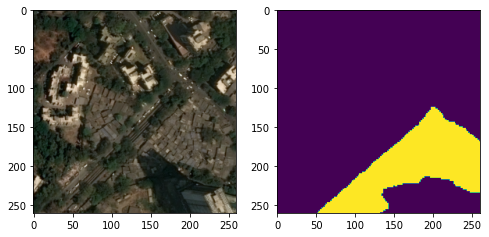

In [16]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(img_rgbraw_png)
ax[1].imshow(tgt_rgbraw_png)

### GDAL parsing of stored 8-bit geotiff data (same function also works for the PNG/JPG sample above but perhaps less efficient)

In [36]:
# this works for Geotiffs, PNG/JPG, etc
img_rgbraw_tif, tgt_rgbraw_tif, id_rgbraw_tif = parse_gdal_example_py(eg_rgbraw_gdal)

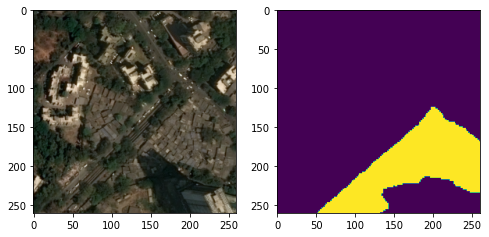

In [37]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(img_rgbraw_tif)
ax[1].imshow(tgt_rgbraw_tif)

### Parsing of >8 bit / >3 bands image stored as encoded GeoTiff data, uses same GDAL parser function

In [39]:
img_tifraw, tgt_tifraw, id_tifraw = parse_gdal_example_py(eg_tifraw)
img_tifraw.shape # this is a np array

(68, 68, 12)

Select and visualise the RGB bands from the returned 12 band array, in the correct order (they are bands 4, 3, 2 respectively, or 3,2,1 in the zero-indexed numbering of the array). 

They are (originally) int16 data with range up to 65536 but normally in the lower end of this range. imshow needs floats 0..1, so to visualise we'll normalise by dividing each band by the max of that band's data in the current tile

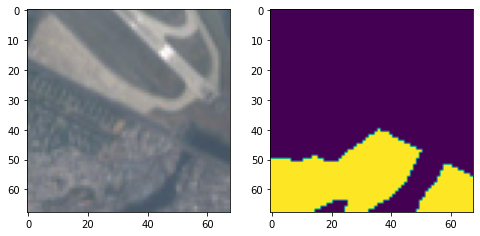

In [12]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
sentinel_rgb = img_tifraw[:,:,3:0:-1]
#sentinel_rgb = sentinel_rgb / (sentinel_rgb.max(axis=(0,1)))
ax[0].imshow(sentinel_rgb / sentinel_rgb.max(axis=(0,1)))
ax[1].imshow(tgt_tifraw)
#ax[1].imshow(trg_ms.numpy().astype(np.uint8)[0].squeeze())

### Parsing of 8-bit image data stored as uncompressed array encoded as BytesList 

(because this takes less space than Float64List if data are 8 bit)

In [11]:
img_rgbarr, tgt_rgbarr, id_rgbarr = parse_8bit_array_proto(eg_rgbarr)

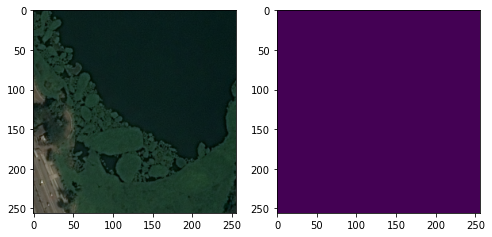

In [12]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(img_rgbarr)
ax[1].imshow(tgt_rgbarr)

In [13]:
img_rgbarr.shape

TensorShape([256, 256, 3])

### Parsing of >8 bit image data stored as uncompressed array encoded as Float64List

(can equally store 8 bit image data in this format as per the DL sample, but it wastes lots of space)

In [14]:
img_tifarr, tgt_tifarr, id_tifarr = parse_higher_dtype_array_proto(eg_tifarr)
img_tifarr.shape # this is a tensor of an array

TensorShape([64, 64, 12])

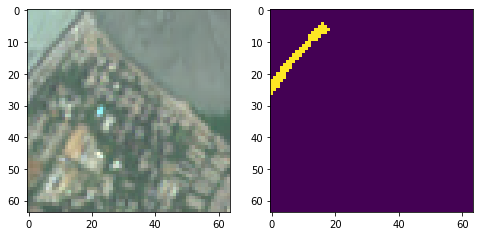

In [15]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
sentinel_rgb = img_tifarr[:,:,3:0:-1].numpy()
#sentinel_rgb = sentinel_rgb / (sentinel_rgb.max(axis=(0,1)))
ax[0].imshow(sentinel_rgb / sentinel_rgb.max(axis=(0,1)))
ax[1].imshow(tgt_tifarr)
#ax[1].imshow(trg_ms.numpy().astype(np.uint8)[0].squeeze())

# Define a parsed version of the whole dataset

We can use dataset.map to define a new view of the dataset in a pipeline in which the images have been parsed using one of the functions introduced above. 

However when we use dataset.map, the mapped function always executes in static graph mode, not eager mode. This doesn't affect our function for parsing PNG/JPG RGB images as that uses only tensorflow code which operates on tensors:

In [20]:
parsed_rgbraws = dataset_rgbraw_png.map(parse_encoded_rgb_img_example, 8)
png_vis = iter(parsed_rgbraws.batch(1))

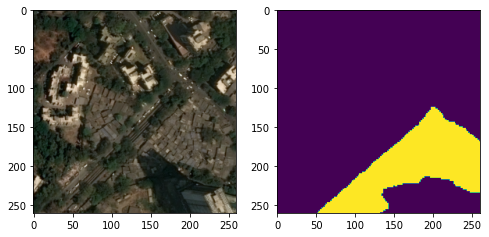

In [21]:
i, t, k = next(png_vis)
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(i[0])
ax[1].imshow(t[0])

### py_function / numpy_function

However the `parse_gdal_example` function needs to access the `.numpy()` of the tensor, and this isn't available in graph mode so we can't just do this: 
```python 
dataset_tifraw.map(parse_gdal_example)
```

Instead we need to wrap it in a `tf.numpy_function` which will I'm sure be slower, but it works. 
See also `tf.py_function`

This requires specifying the output datatypes of the function, but depending on the image types we're using `parse_gdal_example` could return different datatypes. 

For now, we'll just define a wrapper function `parse_gdal_example_tf` in which we call the GDAL parsing code wrapped inside a call to `tf.numpy_function`, with a specified return type of Float32 which will be safe with everything we're likely to use (uint8, uint16, float32)

In [18]:
parsed_np = dataset_tifraw.map(parse_encoded_gdal_proto_wrapped, 8)
parsed_np_vis = iter(parsed_np.batch(1))

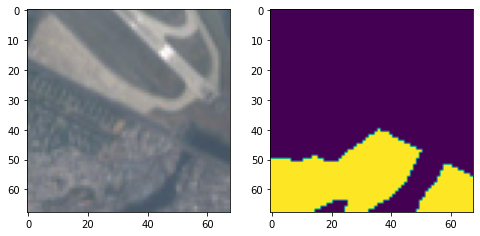

In [19]:
i,t,k = next(parsed_np_vis)
fig, ax = plt.subplots(1,2, figsize=(8,5))
rgb_bands = i[0][:,:,3:0:-1].numpy()
ax[0].imshow(rgb_bands / rgb_bands.max(axis=(0,1)))
ax[1].imshow(t[0])

Alternatively we could wrap the original GDAL parsing function inside a tf.py_function like this:

In [22]:
# https://www.reddit.com/r/tensorflow/comments/f8t68c/how_to_use_tfpy_function_inside_a_datasetmap_to/fiprqkx/?context=8&depth=9
#data = fnames.map(lambda x: tf.py_function(process_path, [x], [tf.string]))
#def make_parser(example):
#    def my_parser(x):
#        parse_gdal_example(x)
#    def tf_parser(x):
#        return tf.py_function(my_parser, [x], [tf.float32, tf.float32, tf.string])
parsed_tifraws = dataset_tifraw.map(lambda x: 
                                    tf.py_function(
                                        parse_encoded_gdal_proto_eager, [x], 
                                        [tf.float32, tf.float32, tf.string]))
tif_raw_vis = iter(parsed_tifraws.batch(1))

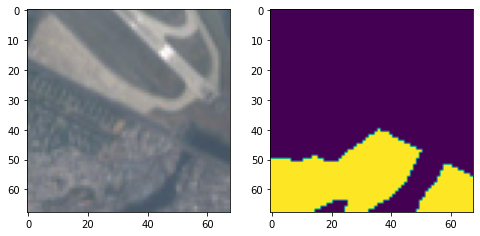

In [23]:
i,t,k = next(tif_raw_vis)
fig, ax = plt.subplots(1,2, figsize=(8,5))
rgb_bands = i[0][:,:,3:0:-1].numpy()
ax[0].imshow(rgb_bands / rgb_bands.max(axis=(0,1)))
ax[1].imshow(t[0])

# WiP below this point

# Manage data in Descartes Labs Storage

In [43]:
import descarteslabs as dl
storage = dl.Storage()

Upload files:

In [42]:
for tf_folder in sudan_datasets:
    tf_files = glob.glob(os.path.join(tf_folder, '*'))
    for f in tf_files:
        storage_name = os.path.basename(os.path.dirname(tf_folder)) + ':' + os.path.basename(f)
        storage.set_file(storage_name, f)

C:\Users\harry\anaconda3\envs\dl_tf_gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Delete files matching a pattern

In [39]:
for f in storage.list():
    if f.startswith(':'):
        storage.delete(f)

C:\Users\harry\anaconda3\envs\dl_tf_gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get a "Signed URL" for a given file in Storage, which anyone can use (temporarily) to download a file from Storage (even from a different user)

In [45]:
storage.get_signed_url('tf_sentinel_SR_arr_nairobi:sentinel_SR_arr_nairobi-00000-of-00012')

C:\Users\harry\anaconda3\envs\dl_tf_gpu\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'https://storage.googleapis.com/storage-18c50f09e09b84842b9c0db4e2f57f97f5e4ea77-data/tf_sentinel_SR_arr_nairobi:sentinel_SR_arr_nairobi-00000-of-00012?GoogleAccessId=storage-service@dl-services-prod.iam.gserviceaccount.com&Expires=1606992095&Signature=NfJGKedGCM%2BxxCsCA8kZHOx0WA/De4XGtiw5cuhg5w73mYkshn28p5Rgsl1MfOYgs5GVjX0Tq0CQdEiPQ%2BuJxk%2BnWpgbfitSFFxCUwW5wK2ZS6YW1qHa3Iiy50ZF0X7b%2BHqU/pveVltIV3Pwpq2iLSI8%2BBWvSgUDPwie8s6vA1GiK8ptNGTaWyKamI2HteIJaB5avPjJx5x6E49sCNw4WKddIpvLZ9vfwbaeiRIjV6WGMF/IFb%2BWi1KtoroweXavp3ZHK2PkDgpd9%2BIj2xWiKYfP4WGtMEYt8MAQXOIROdug4PsS8101fGPt5MU1XhPDyvgSoDdGoAx7AjRVDnaYtw%3D%3D'

Experiment with applying augmentations "manually" (tf modules are all for RGB imagery)

e.g. 
https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic


In [24]:
import scipy.ndimage as ndimage

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


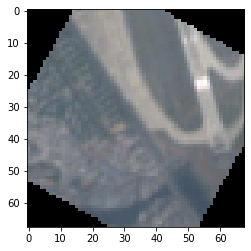

In [40]:
plt.imshow(ndimage.rotate(sentinel_rgb / sentinel_rgb.max(axis=(0,1)), np.random.uniform(-30,30), reshape=False))

Or with tf 2.3 we will be able to use keras layers:
https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2
e.g.

In [65]:
import tensorflow.keras.layers as layers
aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2,fill_mode='reflect', interpolation='bilinear') ])
# not implemented in <2.3

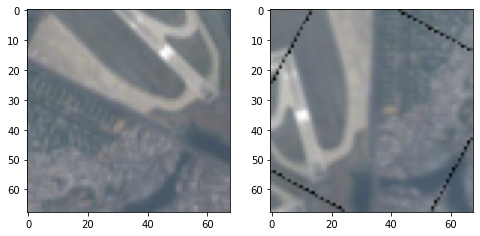

In [67]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
#sentinel_rgb = sentinel_rgb / (sentinel_rgb.max(axis=(0,1)))
ax[0].imshow(sentinel_rgb / sentinel_rgb.max(axis=(0,1)))

new_img = aug(tf.expand_dims(sentinel_rgb, 0))[0]
ax[1].imshow(new_img/new_img.numpy().max(axis=(0,1)) )
#ax[1].imshow(new_img/1400 )

In [71]:
sentinel_rgb[5]

array([[ 797.,  800.,  749.],
       [ 841.,  826.,  763.],
       [ 937.,  877.,  800.],
       [1126.,  975.,  888.],
       [1416., 1190., 1038.],
       [1482., 1227., 1062.],
       [1472., 1203., 1036.],
       [1537., 1258., 1085.],
       [1547., 1259., 1077.],
       [1577., 1281., 1081.],
       [1627., 1340., 1135.],
       [1555., 1312., 1137.],
       [1349., 1151., 1006.],
       [1156., 1005.,  887.],
       [1076.,  971.,  879.],
       [1044.,  943.,  859.],
       [1033.,  921.,  837.],
       [1037.,  915.,  840.],
       [1045.,  918.,  846.],
       [1046.,  926.,  837.],
       [1044.,  936.,  832.],
       [1032.,  935.,  845.],
       [1022.,  931.,  859.],
       [1032.,  932.,  864.],
       [1039.,  930.,  863.],
       [1018.,  917.,  844.],
       [ 995.,  900.,  822.],
       [ 992.,  882.,  819.],
       [ 992.,  866.,  819.],
       [ 982.,  873.,  822.],
       [ 959.,  865.,  803.],
       [ 975.,  884.,  826.],
       [1017.,  911.,  836.],
       [11

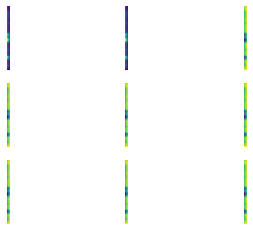

In [42]:
def random_invert_img(x, p=0.5):
    if  tf.random.uniform([]) < p:
        x = (1-x)
    else:
        x
    return x

def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

plt.figure()
for i in range(9):
    augmented_image = random_invert(sentinel_rgb)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy())
    plt.axis("off")

In [43]:
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor

    def call(self, x):
        return random_invert_img(x)

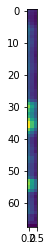

In [44]:
_ = plt.imshow(RandomInvert()(sentinel_rgb)[0])